Data shape: (6000, 784) Labels: (6000,)
Logistic Regression Accuracy: 0.9208
Random Forest Accuracy: 0.9508
Extra Trees Accuracy: 0.9550
Voting Classifier Accuracy: 0.9550

Best model: Extra Trees with accuracy 0.9550


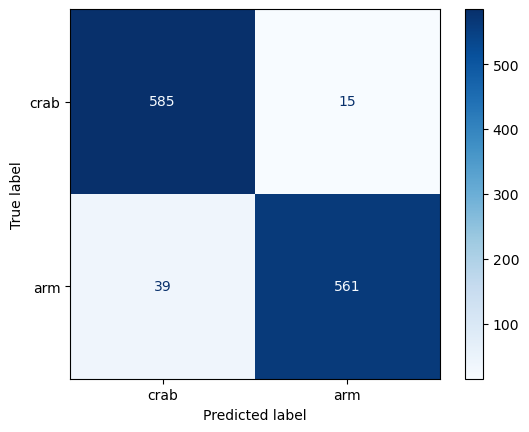

              precision    recall  f1-score   support

        crab       0.94      0.97      0.96       600
         arm       0.97      0.94      0.95       600

    accuracy                           0.95      1200
   macro avg       0.96      0.96      0.95      1200
weighted avg       0.96      0.95      0.95      1200



['doodle_classes.joblib']

In [12]:
import os
import numpy as np
import joblib
import matplotlib.pyplot as plt
from PIL import Image
import glob
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# Settings
DATA_DIR = "doodle"
CATEGORIES = ["crab", "arm"]
IMG_SIZE = 28
N_PER_CLASS = 3000

# Load data
X, y = [], []
for idx, category in enumerate(CATEGORIES):
    folder = os.path.join(DATA_DIR, category)
    files = glob.glob(os.path.join(folder, "*.png"))[:N_PER_CLASS]
    
    for file_path in files:
        img = Image.open(file_path).convert('L') #luminance (gray scale)
        img = img.resize((IMG_SIZE, IMG_SIZE))
        img_array = np.array(img) / 255.0
        X.append(img_array.flatten())
        y.append(idx)

X, y = np.array(X), np.array(y)
print("Data shape:", X.shape, "Labels:", y.shape)

# Split and scale
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, n_jobs=-1),
    "Random Forest": RandomForestClassifier(n_estimators=1000, random_state=42, n_jobs=-1),
    "Extra Trees": ExtraTreesClassifier(n_estimators=1000, random_state=42, n_jobs=-1),
    "Voting Classifier": VotingClassifier([
        ("logreg", LogisticRegression(max_iter=1000, n_jobs=-1)),
        ("rf", RandomForestClassifier(n_estimators=1000, random_state=42, n_jobs=-1)),
        ("et", ExtraTreesClassifier(n_estimators=1000, random_state=42, n_jobs=-1))
    ], voting="hard", n_jobs=-1)
}

# Train and evaluate
best_name, best_model, best_acc = None, None, 0
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    score = model.score(X_test_scaled, y_test)
    print(f"{name} Accuracy: {score:.4f}")
    if score > best_acc:
        best_name, best_model, best_acc = name, model, score

print(f"\nBest model: {best_name} with accuracy {best_acc:.4f}")

# Results
y_pred = best_model.predict(X_test_scaled)
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred), display_labels=CATEGORIES).plot(cmap="Blues")
plt.show()
print(classification_report(y_test, y_pred, target_names=CATEGORIES))

# Save
joblib.dump(best_model, "doodle_model.joblib")
joblib.dump(scaler, "doodle_scaler.joblib")
joblib.dump(CATEGORIES, "doodle_classes.joblib")